In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import linregress
import seaborn as sns

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
sim_colors = {
        "SymphonyLMC": sns.color_palette("colorblind")[4],
        "SymphonyMilkyWay": sns.color_palette("colorblind")[0],
        "SymphonyGroup": sns.color_palette("colorblind")[2],
        "SymphonyLCluster": sns.color_palette("colorblind")[1],
        "SymphonyCluster": sns.color_palette("colorblind")[3],
    }
sim_names = {
        "SymphonyLMC": "LMC",
        "SymphonyMilkyWay": "Milky~Way",
        "SymphonyGroup": "Group",
        "SymphonyLCluster": "L-Cluster",
        "SymphonyCluster": "Cluster",
    }
out_dir = os.path.join(base_dir, "output", "FIGURE")

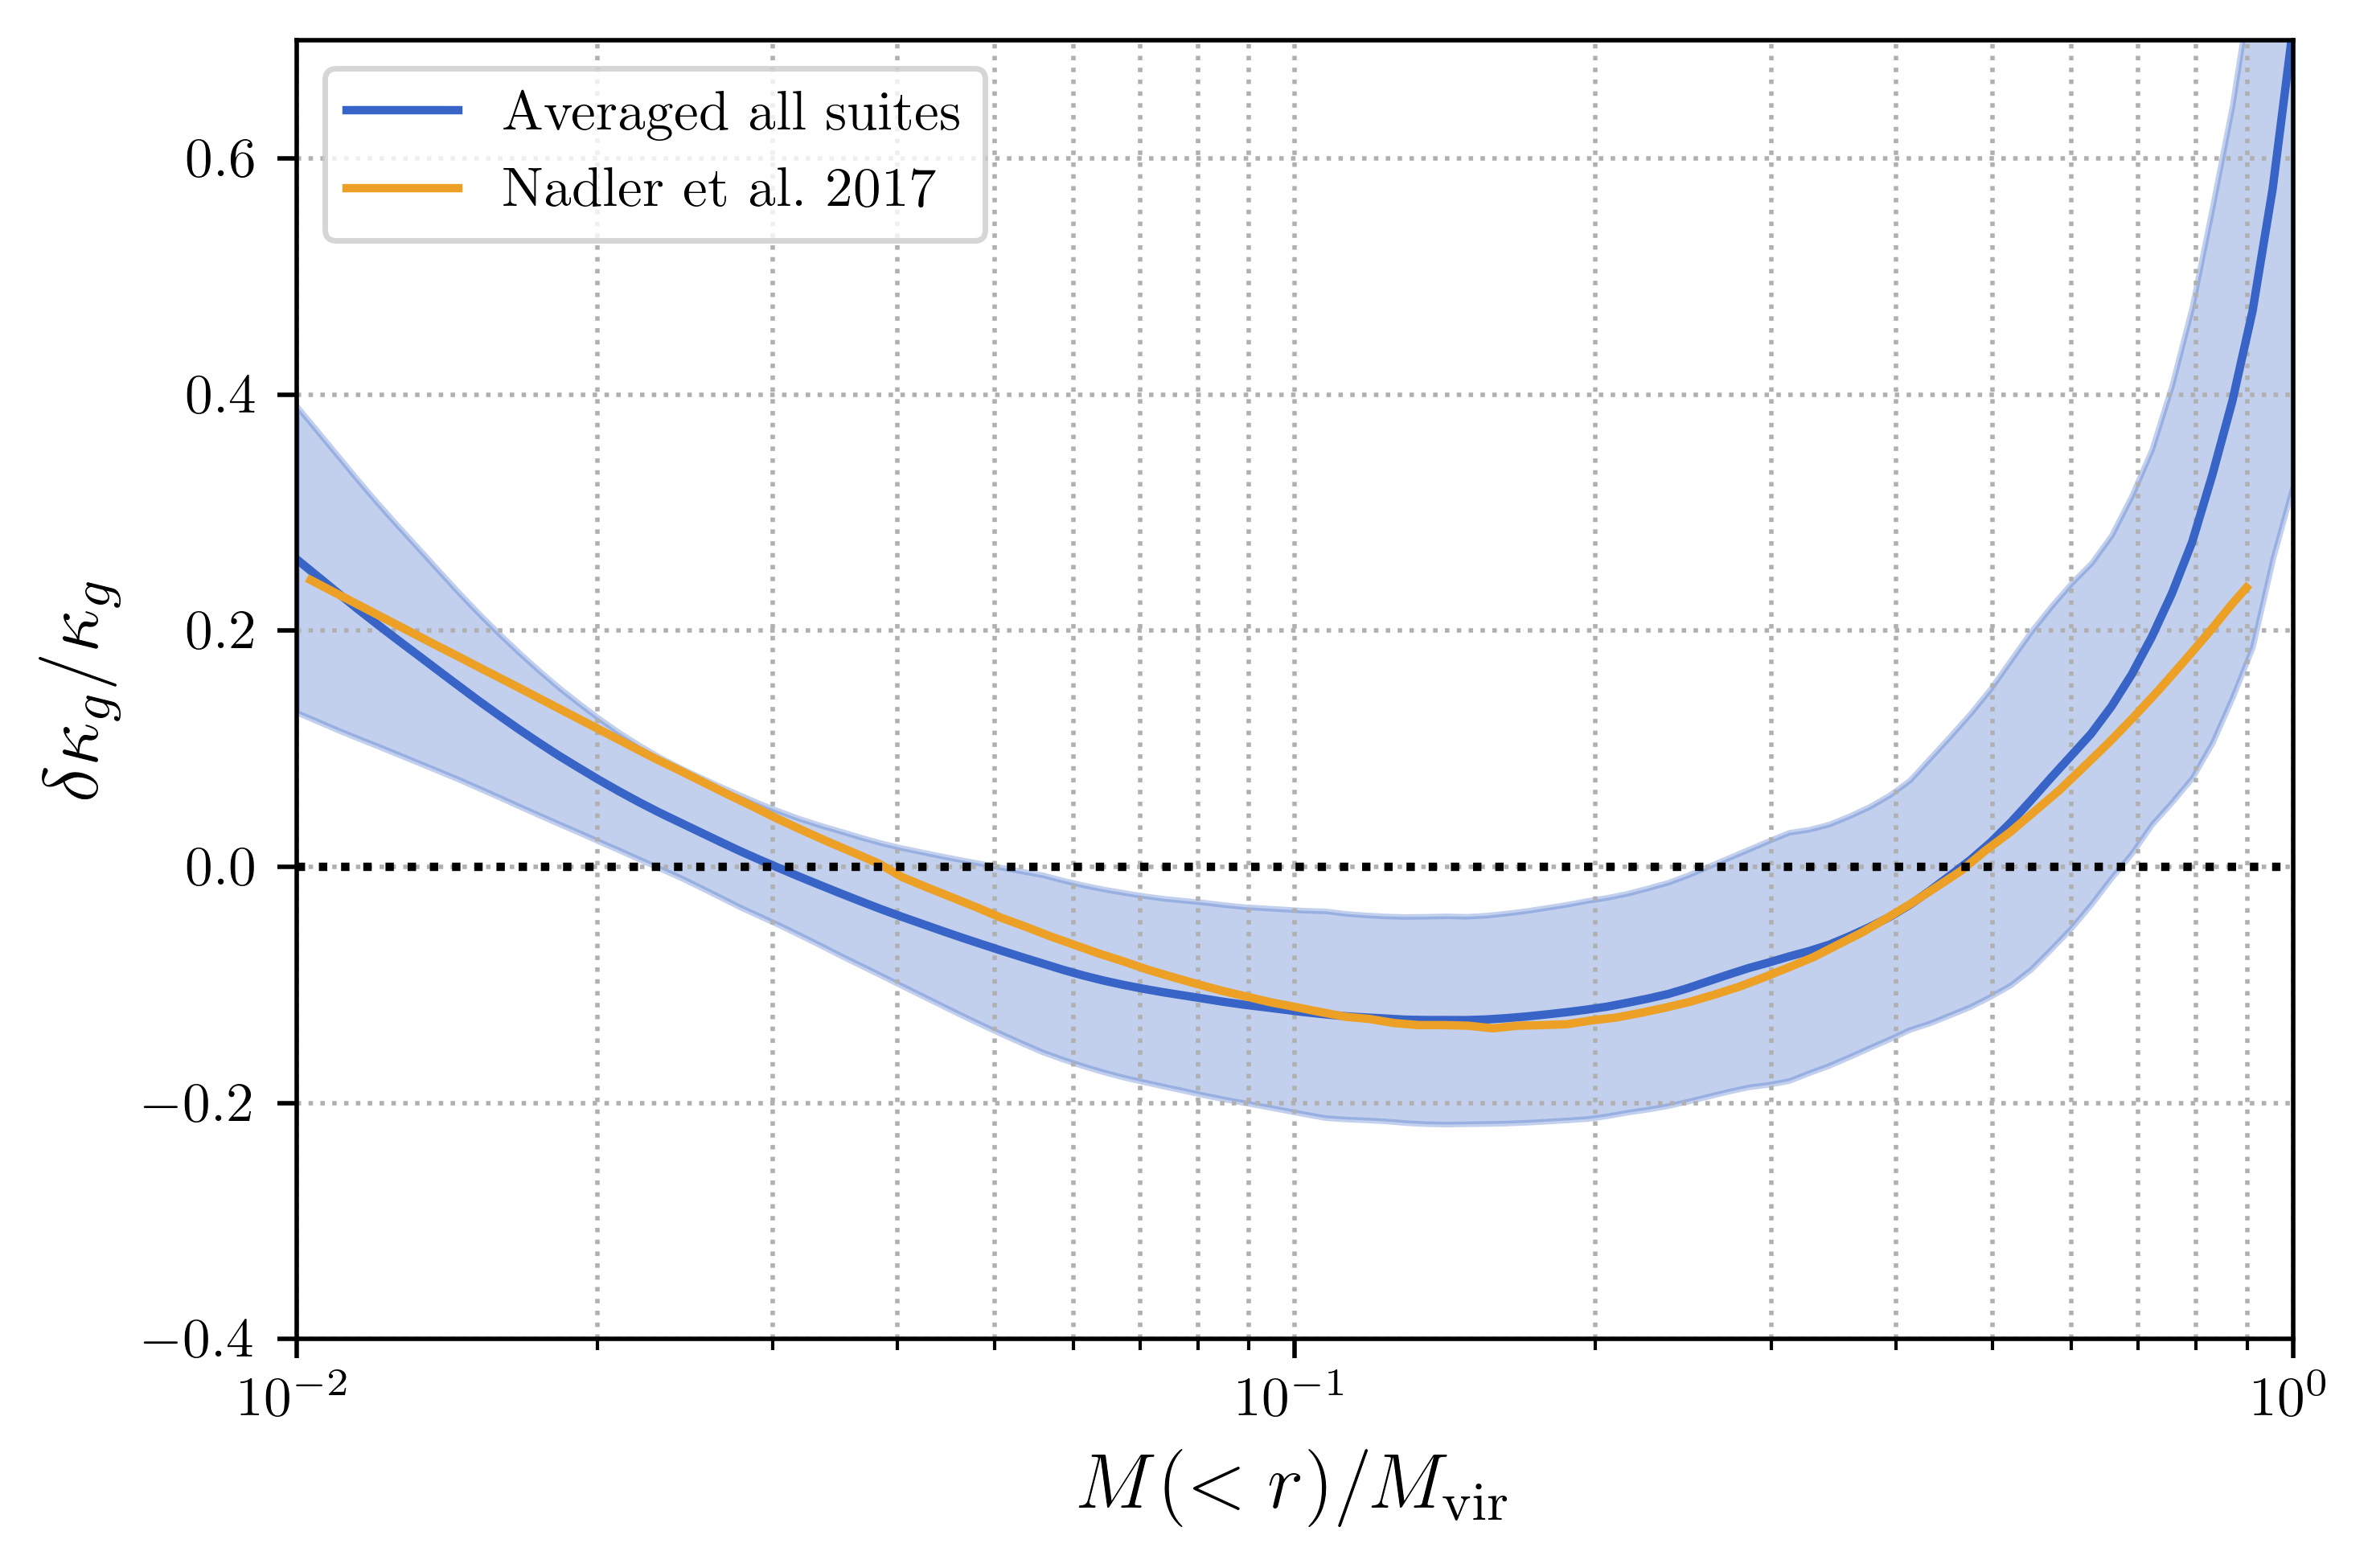

In [3]:
def plot_ppsd_residual_vs_nadler_stacked():
    logm_grid = np.linspace(-2, 0 , 100)
    m_grid = 10**logm_grid
    r_ref, log_r = None, None
    plt.rcParams['text.usetex'] = True
    # Read Nadler reference curves
    nadler_mass = pd.read_csv("/Users/fengbocheng/Projects/Symphony-PPSD/overplot/Nadler+17_figure10a_blue.csv")
    nadler_mass.columns = [c.strip() for c in nadler_mass.columns]

    # ---------- STACK ALL SUITES (vs M) ----------
    residual_m_stack_all = []

    for suite in suite_names:
        profile_dir = os.path.join(base_dir, "output", suite, "ppsd_profiles")

        for f in sorted(f for f in os.listdir(profile_dir) if f.endswith(".csv")):
            df = pd.read_csv(os.path.join(profile_dir, f))
            m, Q = df['m_scaled'].values, df['Q_r'].values

            valid_m = (m > 0) & (Q > 0)
            if np.sum(valid_m) > 5:
                fQm = interp1d(np.log10(m[valid_m]), np.log10(Q[valid_m]),
                               bounds_error=False, fill_value=np.nan)
                logQm = fQm(logm_grid)
                Qm = 10**logQm
                valid_interp = np.isfinite(logQm)
                if np.sum(valid_interp) > 5:
                    slope, intercept, *_ = linregress(logm_grid[valid_interp], logQm[valid_interp])
                    Qm_fit = 10**intercept * m_grid**slope
                    kappa = Qm**(2/3)
                    kappa_fit = Qm_fit**(2/3)
                    residual = (kappa_fit - kappa) / kappa
                    residual_m_stack_all.append(residual)

    residual_m_stack_all = np.array(residual_m_stack_all)
    residual_m_mean = np.nanmean(residual_m_stack_all, axis=0)
    residual_m_std = np.nanstd(residual_m_stack_all, axis=0)

    fig, ax = plt.subplots(figsize=(6, 4), dpi=500)
    ax.plot(m_grid, residual_m_mean, lw=1.5, color="#3764C6", label=r"$\mathrm{Averaged\ all\ suites}$")
    ax.fill_between(m_grid, residual_m_mean - residual_m_std, residual_m_mean + residual_m_std,
                    color='#3764C6', alpha=0.3)
    ax.plot(10**nadler_mass['x'], nadler_mass['y'], label=r'$\mathrm{Nadler~et~al.~2017}$',
            color="#eca026", lw=1.5)
    ax.axhline(0, color='k', linestyle=':')
    ax.set_xscale('log')
    ax.set_xlabel(r'$M(<r)/M_\mathrm{vir}$', fontsize=14)
    ax.set_ylabel(r'$\delta \kappa_g / \kappa_g$', fontsize=14)
    ax.set_xlim(1e-2, 1)
    ax.set_ylim(-0.4, 0.7)
    ax.legend()
    ax.grid(True, linestyle=":", which="both")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "entropy_residual_m_Nadler_stacked.pdf"))
    plt.show()

plot_ppsd_residual_vs_nadler_stacked()


In [ ]:
def plot_ppsd_residual_vs_nadler_stacked():
    r_ref, log_r = None, None

    # Read Nadler reference curves
    nadler_mass = pd.read_csv("/Users/fengbocheng/Projects/Symphony-PPSD/overplot/Nadler+17_figure10a_blue.csv")
    nadler_radius = pd.read_csv("/Users/fengbocheng/Projects/Symphony-PPSD/overplot/Nadler+17_figure10b_blue.csv")
    nadler_mass.columns = [c.strip() for c in nadler_mass.columns]
    nadler_radius.columns = [c.strip() for c in nadler_radius.columns]

    # ---------- STACK ALL SUITES (vs r) ----------
    residual_r_stack_all = []

    # Use a scalar shift for the stack (set to your measured/global median value)
    Rvir_over_Rshock = 0.5
    delta = np.log10(Rvir_over_Rshock)

    r_ref, log_r, log_r_shock = None, None, None

    for suite in suite_names:
        profile_dir = os.path.join(base_dir, "output", suite, "ppsd_profiles")

        for f in sorted(f for f in os.listdir(profile_dir) if f.endswith(".csv")):
            df = pd.read_csv(os.path.join(profile_dir, f))
            r, Q = df['r_scaled'].values, df['Q_r'].values  # r is in units of R_vir

            if r_ref is None:
                r_ref = r
                log_r = np.log10(r_ref)              # log10(r / R_vir)
                log_r_shock = log_r + delta          # log10(r / R_shock) = log_r + delta

            valid = (Q > 0) & (r > 0)
            if np.sum(valid) > 5:
                logQr = np.log10(Q[valid])
                logR  = np.log10(r[valid])           # halo's own log10(r / R_vir)
                slope, intercept, *_ = linregress(logR, logQr)
                Qfit = 10**intercept * r[valid]**slope
                kappa     = Q[valid]**(2/3)
                kappa_fit = Qfit**(2/3)
                residual  = (kappa_fit - kappa) / kappa_fit

                # Interpolate residuals onto the SHOCK-scale grid:
                # log10(r/R_shock) grid is log_r_shock; each halo's x is (logR + delta)
                interp_resid = np.interp(log_r_shock, logR + delta, residual,
                                        left=np.nan, right=np.nan)
                residual_r_stack_all.append(interp_resid)

    residual_r_stack_all = np.array(residual_r_stack_all)
    residual_r_mean = np.nanmean(residual_r_stack_all, axis=0)
    residual_r_std  = np.nanstd(residual_r_stack_all, axis=0)

    # Plot on Nadler's shock scale (x = log10(r/R_shock)); Nadler stays unshifted
    plt.figure(figsize=(6, 4), dpi=500)
    plt.plot(log_r_shock, residual_r_mean, lw=1.5, color='#3764C6',
            label=r'$\mathrm{Simulation\ ensemble\ mean}$')
    plt.fill_between(log_r_shock, residual_r_mean - residual_r_std, residual_r_mean + residual_r_std,
                    color='#3764C6', alpha=0.3)

    # Nadler: already in log10(r/R_shock)
    plt.plot(nadler_radius['x'].values, nadler_radius['y'].values,
            label=r'$\mathrm{Nadler~et~al.~(2017)}$', color='black', lw=1.5)

    plt.axhline(0, color='k', linestyle=':')
    plt.xlabel(r'$\log(\lambda_\mathrm{shock})\ \ (\lambda_\mathrm{shock}=r/R_{\mathrm{shock}})$', fontsize=15)
    plt.ylabel(r'$\delta \kappa_g / \kappa_g$', fontsize=15)
    plt.xlim(-2, 0)
    plt.ylim(-0.5, 0.5)
    plt.legend()
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "entropy_residual_r_Nadler_stacked_ON_shock_scale.pdf"))
    plt.show()


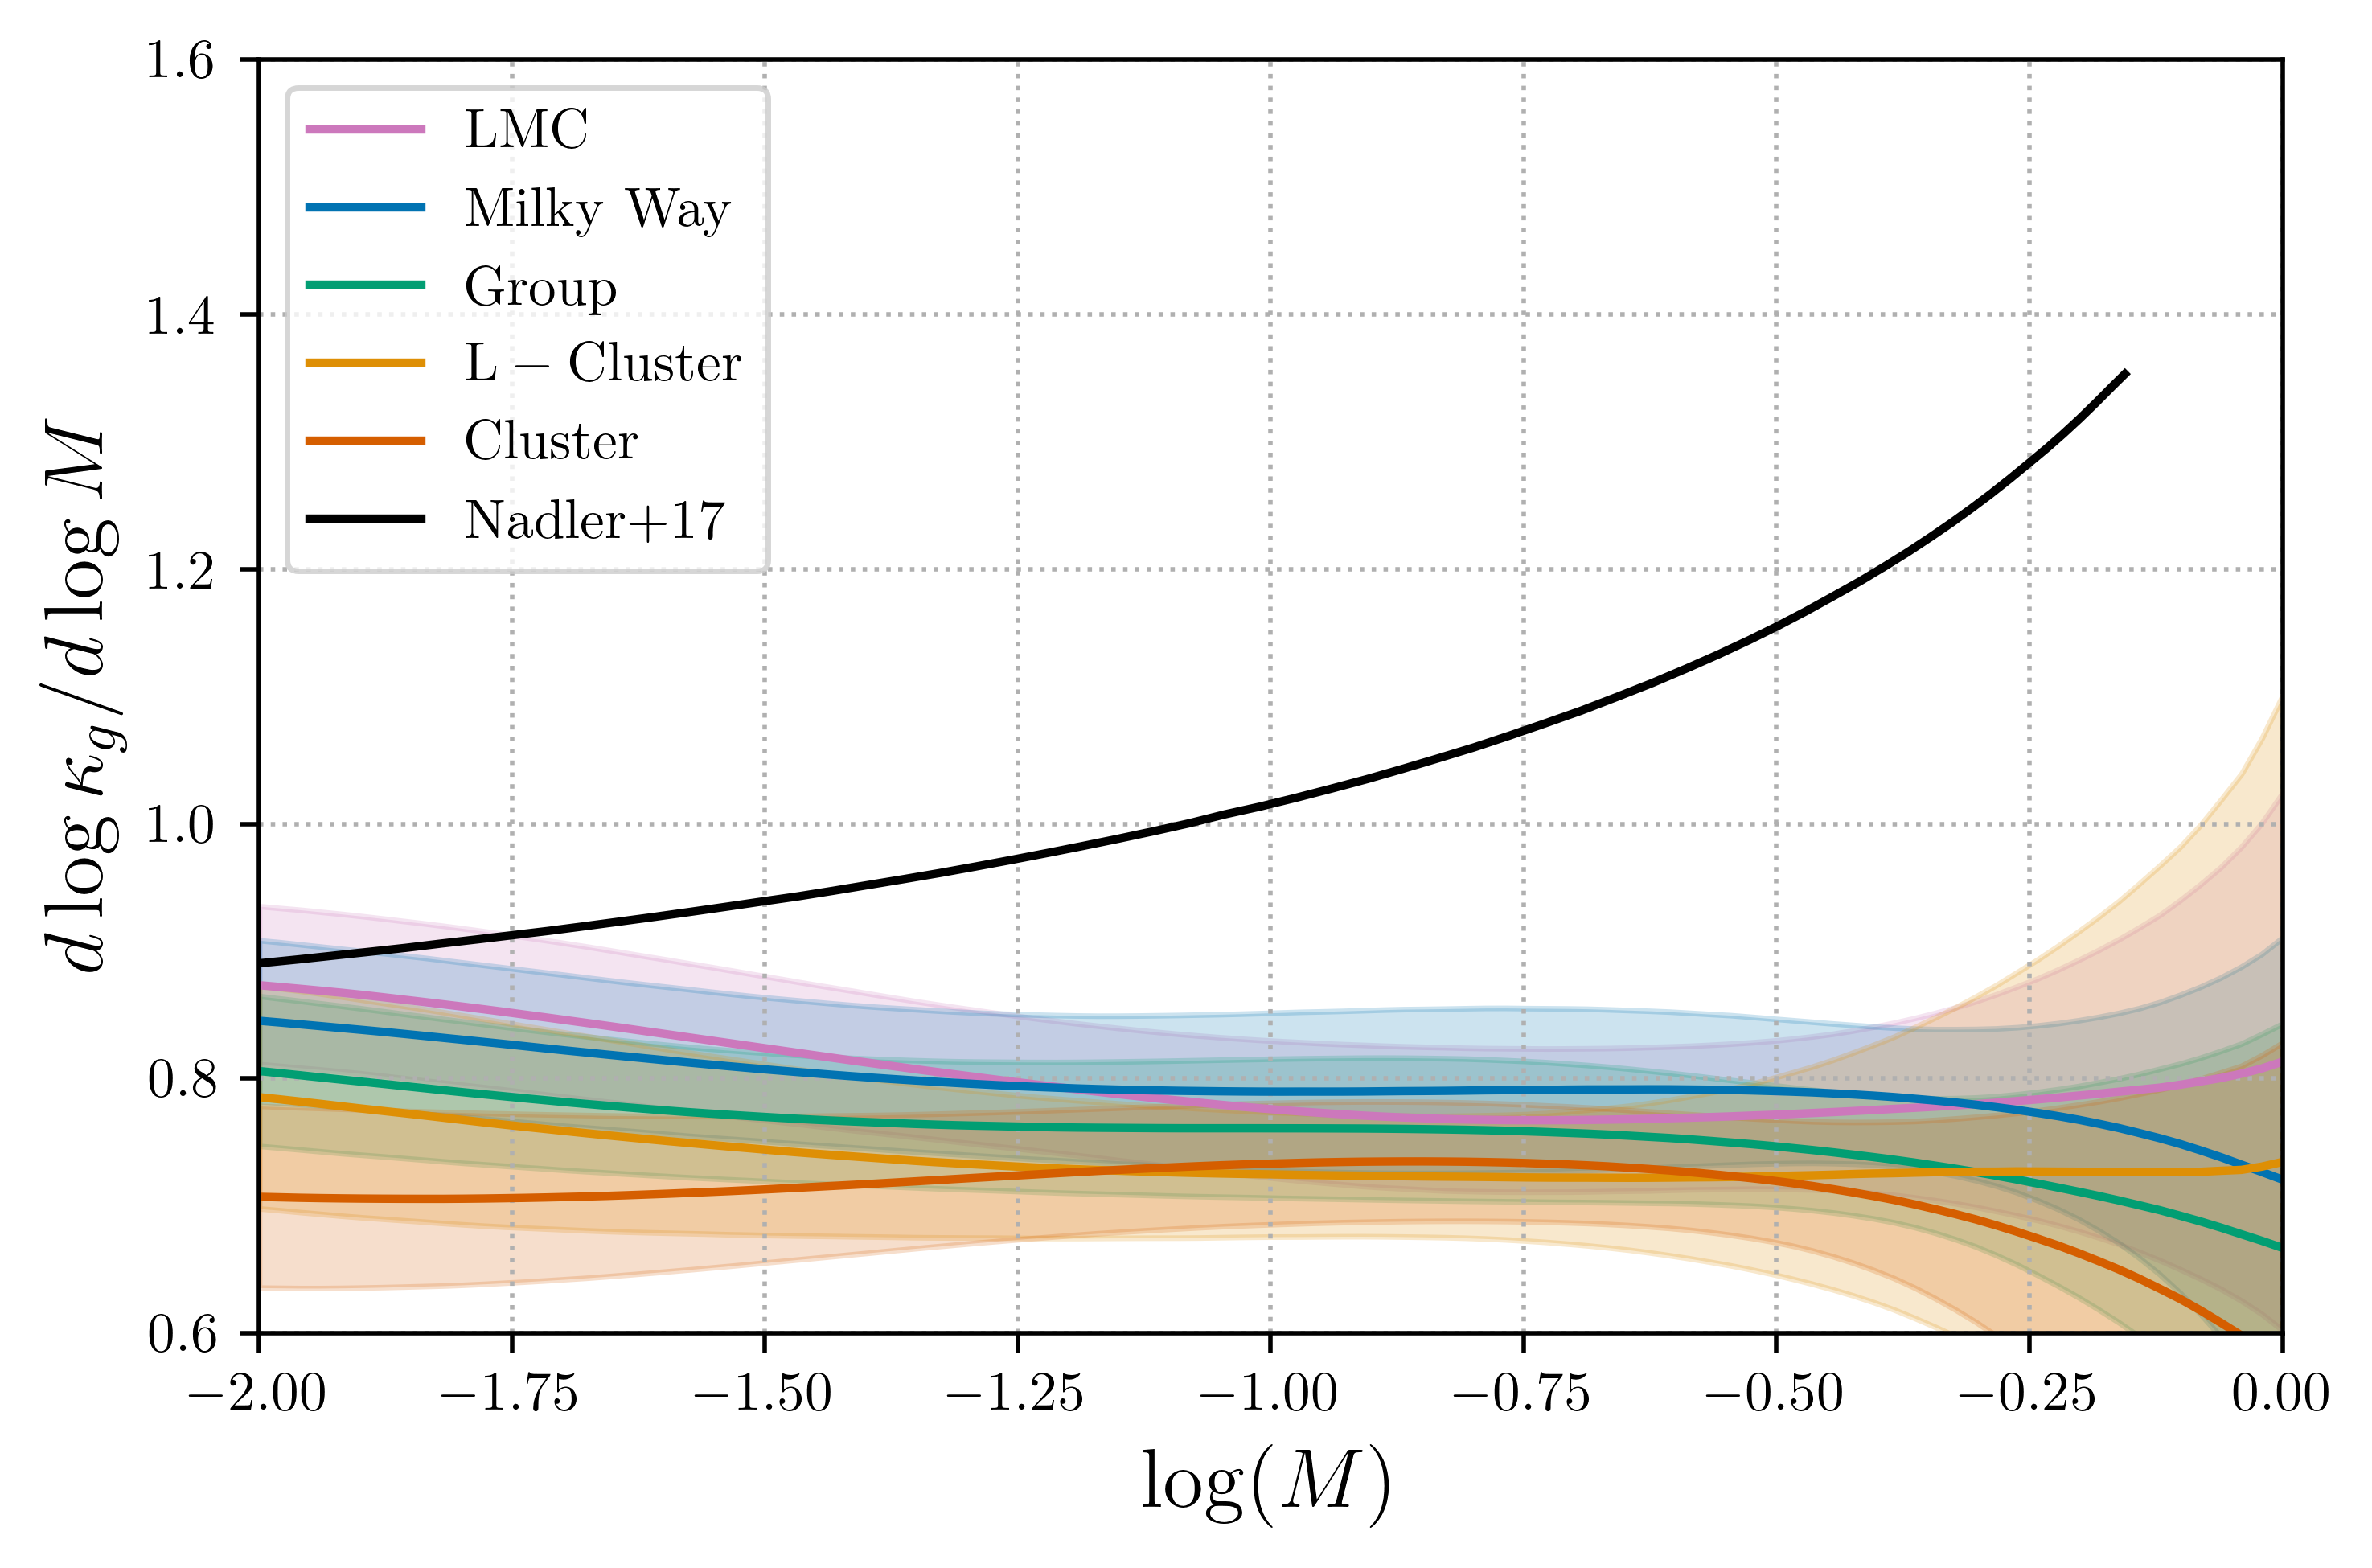

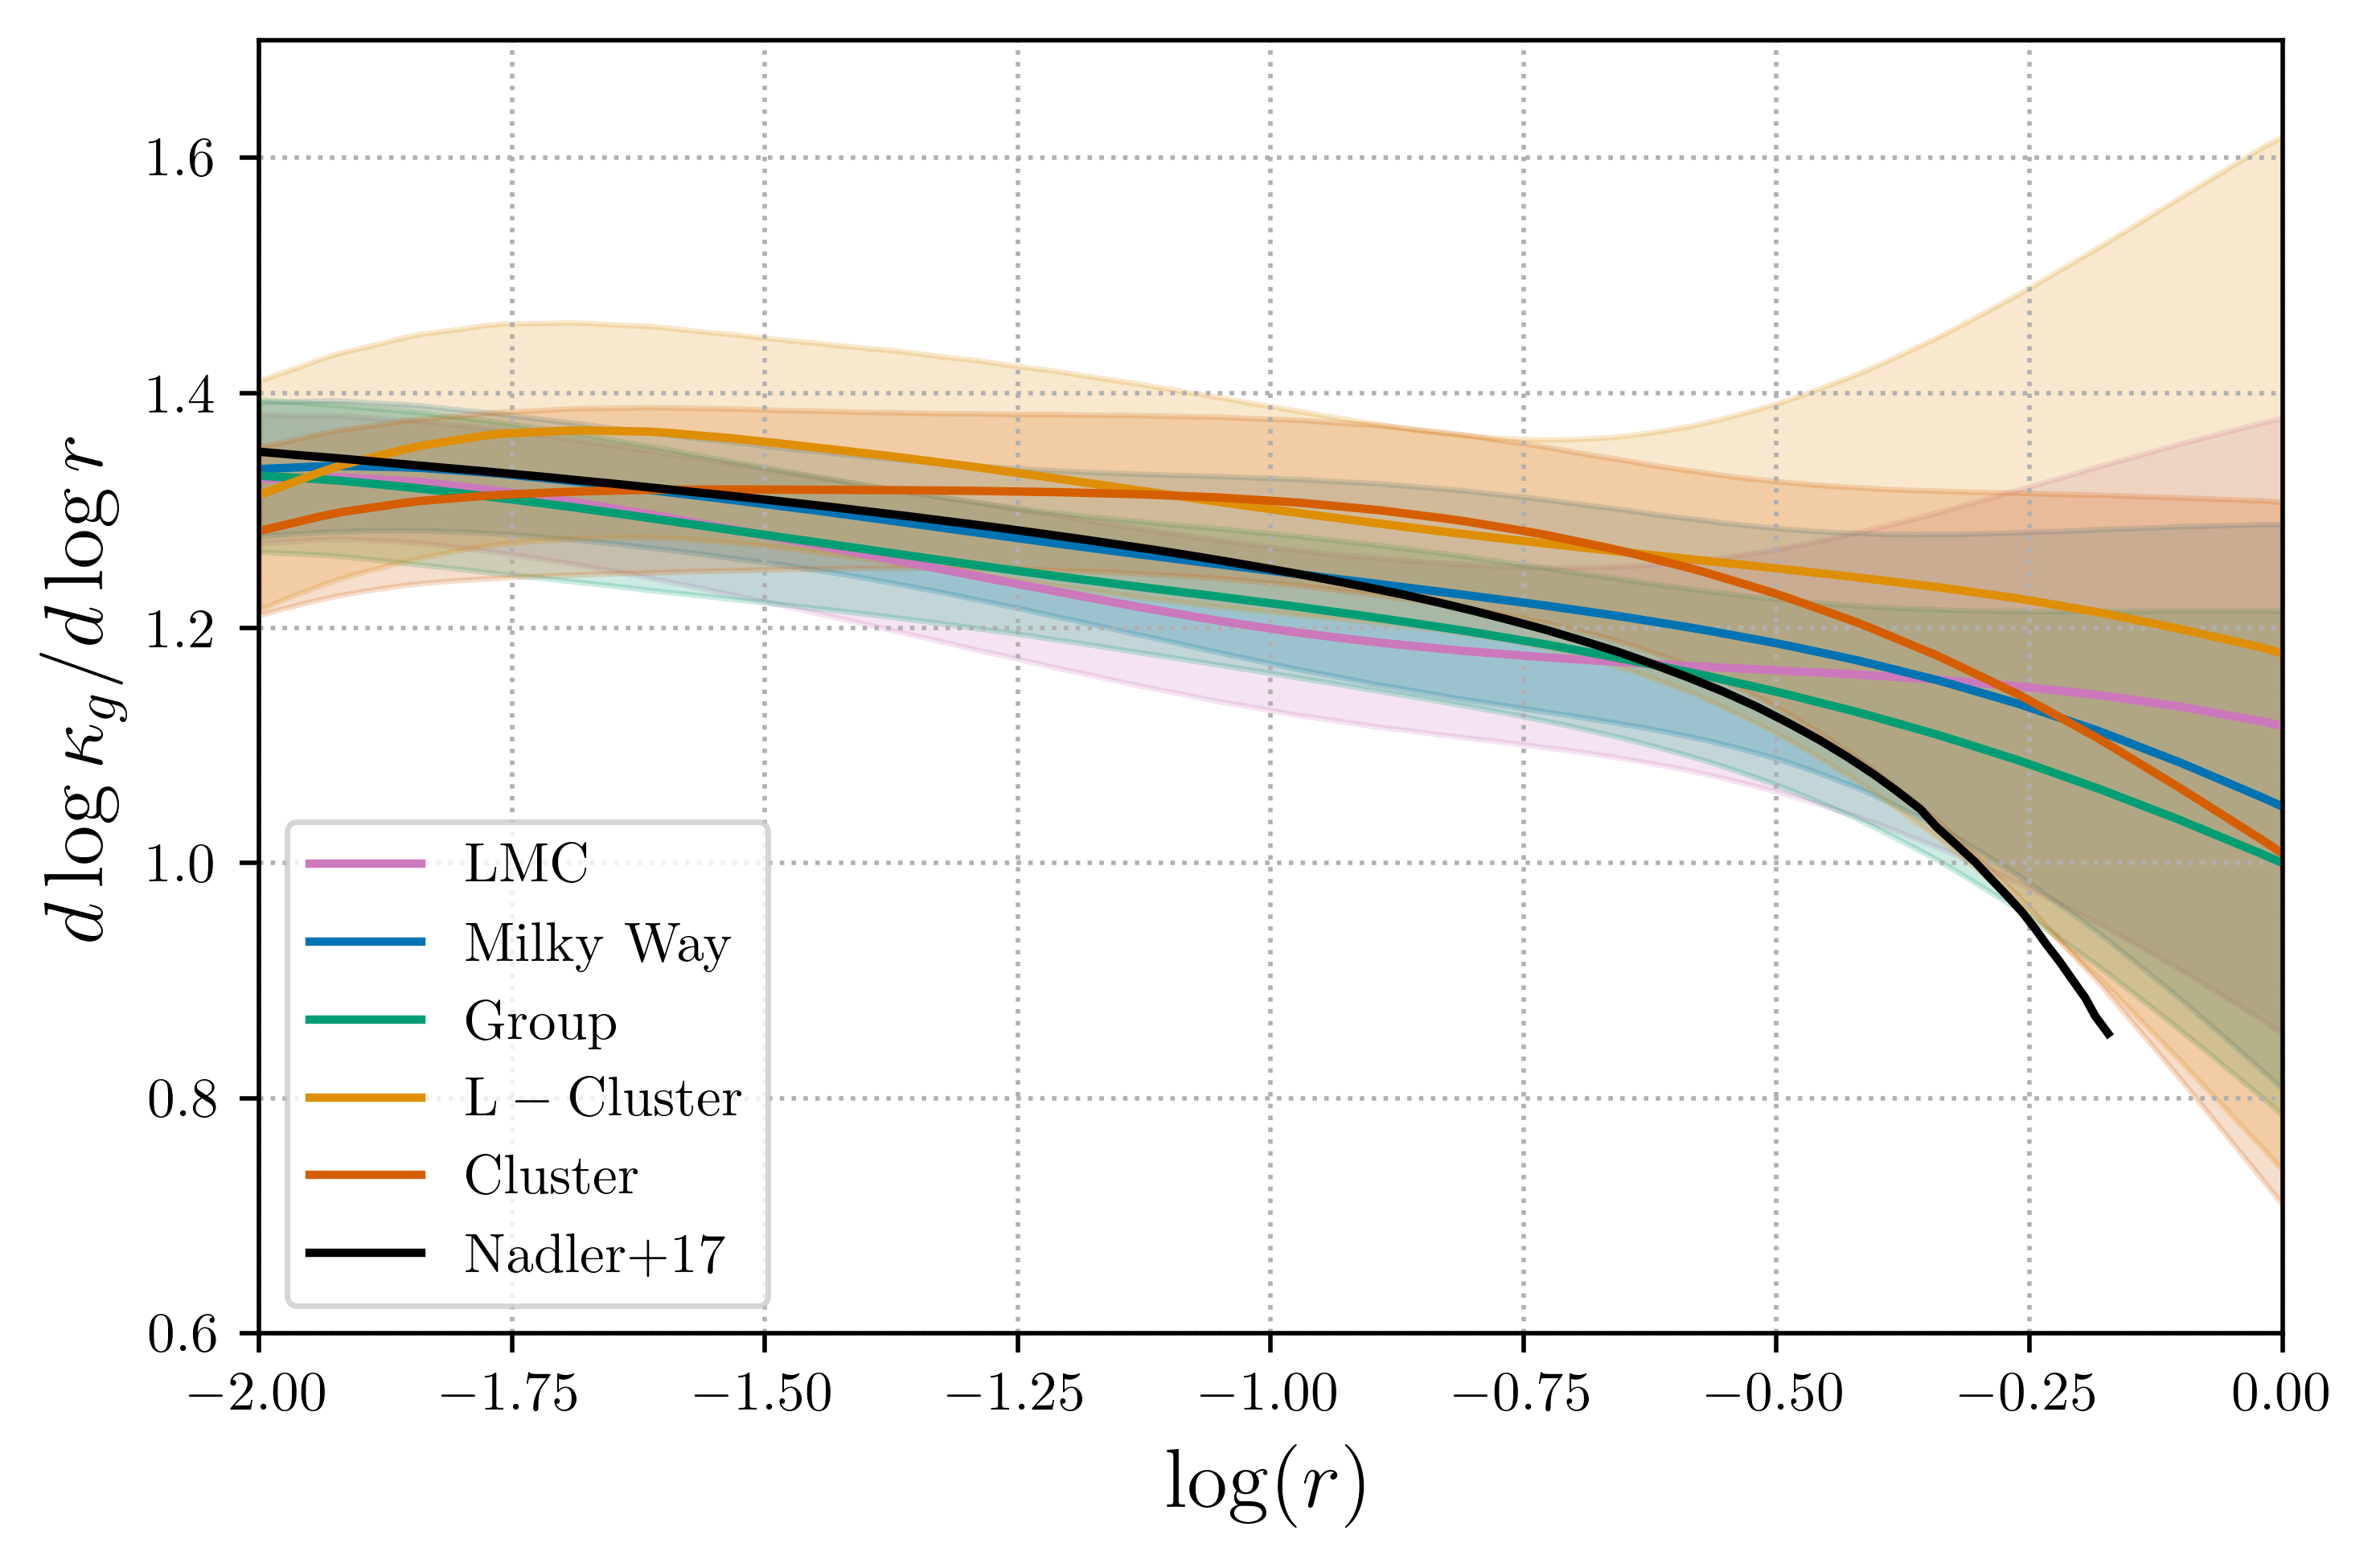

In [13]:
def plot_entropy_slope_from_precomputed():
    logm_grid = np.linspace(-2, 0, 100)
    logr_grid = np.linspace(-2, 0, 100)

    # Load Nadler reference slope curves (entropy)
    nadler_slope_m = pd.read_csv("/Users/fengbocheng/Projects/Symphony-PPSD/overplot/Nadler+17_figure7a_blue.csv")
    nadler_slope_r = pd.read_csv("/Users/fengbocheng/Projects/Symphony-PPSD/overplot/Nadler+17_figure8a_blue.csv")
    nadler_slope_m.columns = [c.strip() for c in nadler_slope_m.columns]
    nadler_slope_r.columns = [c.strip() for c in nadler_slope_r.columns]

    # --- Entropy slope vs log(M) ---
    plt.rcParams['text.usetex'] = True
    plt.figure(figsize=(6, 4), dpi=500)

    for suite in suite_names:
        slope_m_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_m")
        interp_stack = []

        for f in sorted(os.listdir(slope_m_dir)):
            if not f.endswith(".csv"):
                continue
            df = pd.read_csv(os.path.join(slope_m_dir, f))
            m = df["m_scaled"].values
            slope_q = df["slope_Q_r"].values
            valid = (m > 0) & np.isfinite(slope_q)
            if np.sum(valid) < 5:
                continue
            logm = np.log10(m[valid])
            slope_kappa = -2/3 * slope_q[valid]
            f_interp = interp1d(logm, slope_kappa, bounds_error=False, fill_value=np.nan)
            interp_stack.append(f_interp(logm_grid))

        if len(interp_stack) == 0:
            continue

        interp_stack = np.array(interp_stack)
        slope_mean = np.nanmean(interp_stack, axis=0)
        slope_std = np.nanstd(interp_stack, axis=0)

        color = sim_colors[suite]
        plt.plot(logm_grid, slope_mean, lw=1.5, label=rf"$\mathrm{{{sim_names[suite]}}}$", color=color)
        plt.fill_between(logm_grid, slope_mean - slope_std, slope_mean + slope_std, color=color, alpha=0.2)

    plt.plot(nadler_slope_m['x'], nadler_slope_m['y'], label=r'$\mathrm{Nadler{+}17}$', color='black', lw=1.5)
    plt.xlabel(r'$\log(M)$', fontsize=15)
    plt.ylabel(r'$d\log \kappa_g / d\log M$', fontsize=15)
    plt.xlim(-2, 0)
    plt.ylim(0.6, 1.6)
    plt.grid(True, which="major", linestyle=":")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "entropy_slope_m_Nadler.pdf"))
    plt.show()

    # --- Entropy slope vs log(r) ---
    plt.figure(figsize=(6, 4), dpi=500)

    for suite in suite_names:
        slope_r_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        interp_stack = []

        for f in sorted(os.listdir(slope_r_dir)):
            if not f.endswith(".csv"):
                continue
            df = pd.read_csv(os.path.join(slope_r_dir, f))
            r = df["r_scaled"].values
            slope_q = df["slope_Q_r"].values
            valid = (r > 0) & np.isfinite(slope_q)
            if np.sum(valid) < 5:
                continue
            logr = np.log10(r[valid])
            slope_kappa = -2/3 * slope_q[valid]
            f_interp = interp1d(logr, slope_kappa, bounds_error=False, fill_value=np.nan)
            interp_stack.append(f_interp(logr_grid))

        if len(interp_stack) == 0:
            continue

        interp_stack = np.array(interp_stack)
        slope_mean = np.nanmean(interp_stack, axis=0)
        slope_std = np.nanstd(interp_stack, axis=0)

        color = sim_colors[suite]
        plt.plot(logr_grid, slope_mean, lw=1.5, label=rf"$\mathrm{{{sim_names[suite]}}}$", color=color)
        plt.fill_between(logr_grid, slope_mean - slope_std, slope_mean + slope_std, color=color, alpha=0.2)

    plt.plot(nadler_slope_r['x'], nadler_slope_r['y'], label=r'$\mathrm{Nadler{+}17}$', color='black', lw=1.5)
    plt.xlabel(r'$\log(r)$', fontsize=15)
    plt.ylabel(r'$d\log \kappa_g / d\log r$', fontsize=15)
    plt.xlim(-2, 0)
    plt.ylim(0.6, 1.7)
    plt.grid(True, which="major", linestyle=":")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "entropy_slope_r_Nadler.pdf"))
    plt.show()

plot_entropy_slope_from_precomputed()